# 2. Neural network
This notebook demonstrates solving the 1D Burgers Equation using a physics-informed neural network (PINNs).


We'll go over the following:
- How I apply the PINN method to solve the 1D Burgers equation
- Some example results from my implementation

A more thorough study of the performance is saved for the comparison between methods.


In [1]:
using Pkg
Pkg.activate("..") # activate BurgersJoint environment
Pkg.instantiate() # install all dependencies if necessary
using BurgersJoint
using BurgersJoint.BurgersEquation
using BurgersJoint.NeuralNetwork
using Plots

  Activating project at `~/Documents/ACFPD/Individual assignment/BurgersJoint`


## Physics-informed neural networks (PINNs) for the 1D Burgers equation

A physics-informed neural network (PINN) is a type of neural network that incorporates physical laws into its training process. This allows the network to learn not only from data but also from the underlying physics governing the problem (i.e. the governing equations). PINNs are particularly useful for solving partial differential equations (PDEs) such as the Burgers equation.

The following assumes that the reader is already familiar with neural networks. We will employ a multilayer perceptron (MLP) architecture with four fully connected layers. The architecture is as follows:
1. Input layer: 2 inputs (x, t), 16 neurons, sigmoid activation function
2. Hidden layer: 16 neurons, sigmoid activation function
3. Hidden layer: 16 neurons, sigmoid activation function
4. Output layer: 1 output (u), no activation function

Note that I initially also wanted to implement a Kolmogorov-Arnold network (KAN) and compare it to MLPs, but I didn't have time to play with this yet.

I choose to use simple grid training with spatial step $\Delta x = 2(N-1)$ and temporal step $\Delta t$, where $N$ is the number of grid points. The spatial grid is uniformly distributed in the domain $[-1, 1]$ whereas the temporal grid is uniformly distributed in the domain $[0, T]$. I chose this as it trains faster on CPU than more robust strategies like stochastic, quasi-random, or quadrature sampling, as I haven't managed to get GPU acceleration working yet (I blame Linux drivers).

I use the following loss functions for training:
- PDE loss: Represents the residuals of the PDEs at specified collocation points. This is done by applying the differential operators of the PDE system to the neural network's trial solution and penalizing deviations by the mean squared error (MSE).
- BC loss: MSE between the trial solution and the boundary conditions at the specified collocation points (includes actualy BCs, but also initial conditions and potentially other constraints on values of $u$ such as symmetry).

So no information about the solution

Reverse-mode automatic differentiation (AD) is used to calculate gradients of the loss functions with respect to the neural network parameters. The Broyden-Fletcher-Goldfarb-Shanno algorithm (BFGS) is used to optimize the loss function based on the gradients with a maximum of 3000 iterations.

## Example results
Let us look at a few example solutions using the Fourier spectral methods. We will use the following parameters unless otherwise specified:
- Domain $x\in[-1,1]$
- Viscosity $\nu = 10^{-2}/\pi$
- Initial condition $u(x,0) = -\sin(x)$
- Number of grid points $N = 32$
- Time step $\Delta t = 0.01$ (only used for grid training)
- Total time $T = 4/\pi$

Training PINN 100%|██████████████████████████████████████| Time: 0:06:04:49


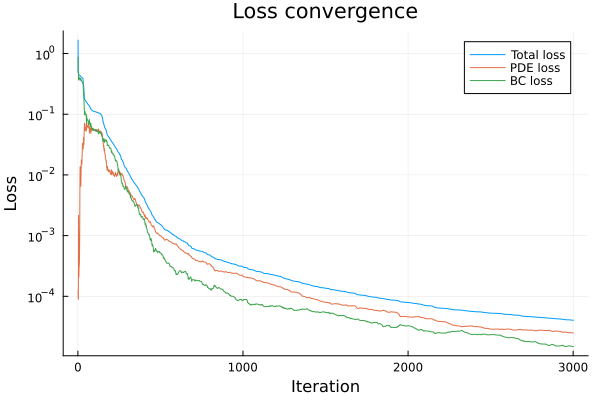

[ Info: Using existing trained model.


(-1.0:0.06451612903225806:1.0, [-0.0006613863993767399, 0.04073005040334543, 0.08180090255371009, 0.12253311922129573, 0.16292964218083372, 0.2030151014060193, 0.24284230751735358, 0.2825009182092757, 0.32212379104379496, 0.36187961147930503  …  -0.363200930574028, -0.3234682612938926, -0.28336874024077674, -0.2429364320413907, -0.20226442160204305, -0.16148852667013602, -0.12077160551826349, -0.08028820470090925, -0.04020839501417783, -0.0006796220896283511], 0.0:0.3183098861837907:1.2732395447351628, [[0.0004908091552919824, 0.20612094889415, 0.39553742490392896, 0.5682658188199371, 0.7210537203479339, 0.8477563730931585, 0.9403994974440105, 0.9920089303088635, 0.999746904914399, 0.965245834819094  …  -0.9656221190143954, -1.001451548734173, -0.9925552184184436, -0.9390737315899753, -0.8465440073561523, -0.72166373198064, -0.5700646563369163, -0.39614448654244594, -0.20411751181802162, 0.0003138680510121894], [-0.0006668823789097722, 0.10274748326154137, 0.20420835636403334, 0.303482

In [ ]:
# Parameter choices:
N   = 32    # number of grid points
dt   = 1e-2   # time step
T = 4/pi    # final time
dt_snapshot = 1/pi # time between solution snapshots
# with these settings, training takes ~ 5 min on my laptop

trainNeuralNetwork(N; T=T, dt=dt)

It seems that 3000 iterations is not enough to fully converge to a solution, but the results are still within $\sim 10^{-4}$ of the true solution on the considered grid. 

We now look at the numerical solution versus analytical solution at different times:

[ Info: Using existing trained model.


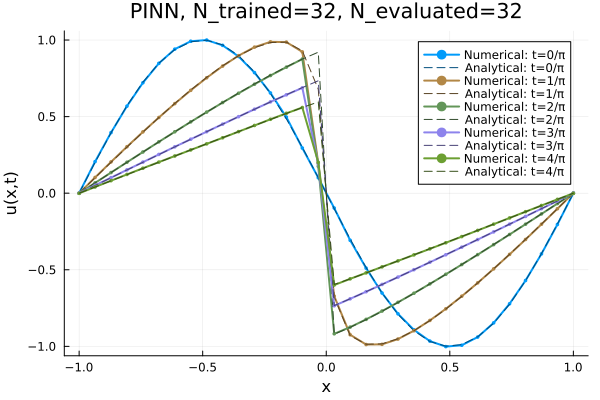

In [22]:
x, u_final, snapshot_times, snapshots = solveNeuralNetwork(N; dt=dt, T=T, dt_snapshot=dt_snapshot)

function plot_sol(method_name)
      plt = plot(title="$method_name", xlabel="x", ylabel="u(x,t)")
      pal = palette(:auto, length(snapshot_times))  # get default palette colors

      # Darken the analytical color by reducing brightness
      f = 0.5

      for (i, t) in enumerate(snapshot_times)
            num_color = pal[i]
            analytical_color = RGB(num_color.r * f, num_color.g * f, num_color.b * f)
            plot!(plt, x, snapshots[i], label="Numerical: t=$(i-1)/π", lw=2, color=num_color, marker=:circle, markersize=2, markerstrokewidth=0)
            plot!(plt, x, analytical_solution(x, t), label="Analytical: t=$(i-1)/π", lw=1, linestyle=:dash, color=analytical_color)
      end

      display(plt)
end

plot_sol("PINN, N_trained=32, N_evaluated=32")

This looks very close to the analytical solution, especially compared to the other methods with similar grid spacing. The solution appears to deviate at the grid point just at the left of $x=0$. This is probably due to the gradient of the solution being the highest around there. The solution here could probably be improved with a more robust training strategy (e.g. stochastic sampling).

If we use the same trained model (trained with grid spacing $N=32$), but evaluate it on a grid with $N=64$, we get:

[ Info: Using existing trained model.


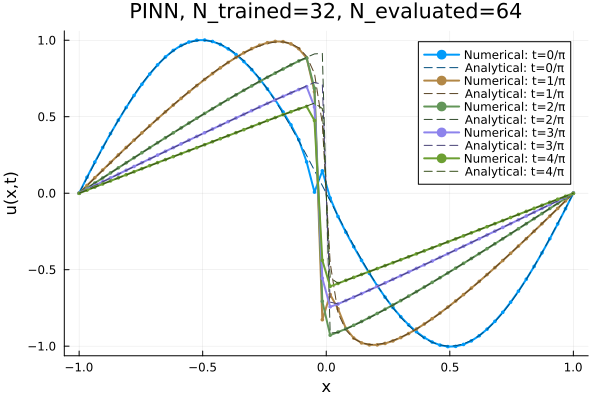

In [21]:
x, u_final, snapshot_times, snapshots = solveNeuralNetwork(64; dt=dt, T=T, dt_snapshot=dt_snapshot)
plot_sol("PINN, N_trained=32, N_evaluated=64")

It seems it is possible to generalize the model to a finer grid spacing with similar error (qualitatively), indicating overfitting is not a major problem. Again, deviations are seen around the center of the domain, even at $t=0$, where the solution should be smooth. 